In [2]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt

In [4]:
class Connect4Env(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, render_mode=None):
        super().__init__()
        self.rows = 6
        self.cols = 7
        self.observation_space = spaces.Box(low=0, high=2, shape=(42,), dtype=np.int8)
        self.action_space = spaces.Discrete(self.cols)
        self.render_mode = render_mode
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.board = np.zeros((self.rows, self.cols), dtype=np.int8)
        self.done = False
        self.info = {"winner": None}
        return self._get_obs(), self.info

    def _get_obs(self):
        return self.board.flatten()

    def step(self, action):
        valid = self._drop_piece(action, player=1)
        if not valid:
            reward = -1.0
            terminated = True
            truncated = False
            return self._get_obs(), reward, terminated, truncated, self.info

        if self._check_win(player=1):
            reward = 1.0
            terminated = True
            truncated = False
            self.info["winner"] = "agent"
            return self._get_obs(), reward, terminated, truncated, self.info

        if np.all(self.board != 0):
            reward = 0.0
            terminated = True
            truncated = False
            return self._get_obs(), reward, terminated, truncated, self.info

        opponent_action = self._get_opponent_action()
        self._drop_piece(opponent_action, player=2)

        if self._check_win(player=2):
            reward = -1.0
            terminated = True
            truncated = False
            self.info["winner"] = "opponent"
            return self._get_obs(), reward, terminated, truncated, self.info

        reward = 0.0
        terminated = False
        truncated = False
        return self._get_obs(), reward, terminated, truncated, self.info

    def _drop_piece(self, col, player):
        if col < 0 or col >= self.cols:
            return False
        for row in reversed(range(self.rows)):
            if self.board[row, col] == 0:
                self.board[row, col] = player
                return True
        return False

    def _check_win(self, player):
        b = self.board
        rows, cols = self.rows, self.cols

        # horizontal
        for r in range(rows):
            for c in range(cols - 3):
                if all(b[r, c + i] == player for i in range(4)):
                    return True

        # vertical
        for r in range(rows - 3):
            for c in range(cols):
                if all(b[r + i, c] == player for i in range(4)):
                    return True

        # diagonal (downward diagonal)
        for r in range(rows - 3):
            for c in range(cols - 3):
                if all(b[r + i, c + i] == player for i in range(4)):
                    return True

        # diagonal (upward diagonal)
        for r in range(3, rows):
            for c in range(cols - 3):
                if all(b[r - i, c + i] == player for i in range(4)):
                    return True

        return False

    def _get_opponent_action(self):
        valid_columns = []
        for col in range(self.cols):
            if self.board[0, col] == 0:
                valid_columns.append(col)
        if len(valid_columns) > 0:
            return np.random.choice(valid_columns)
        return 0

    def render(self):
        print(self.board)
        print()

In [5]:
class LossLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.losses = []  # loss values
        self.timesteps = []  # corresponding timesteps

    def _on_step(self) -> bool:
        # Log loss every 100 steps
        if self.n_calls % 100 == 0:
            loss = self.model.logger.name_to_value.get("train/loss", np.nan)
            if not np.isnan(loss):
                self.losses.append(loss)
                self.timesteps.append(self.num_timesteps)
                print(f"Step: {self.num_timesteps}, Loss: {loss}")
        return True


Streaming output truncated to the last 5000 lines.
|    time_elapsed     | 967      |
|    total_timesteps  | 490473   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00239  |
|    n_updates        | 122368   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.43     |
|    ep_rew_mean      | 0.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 60484    |
|    fps              | 507      |
|    time_elapsed     | 967      |
|    total_timesteps  | 490494   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0367   |
|    n_updates        | 122373   |
----------------------------------
Step: 490500, Loss: 0.00575249781832099
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.44     |
|    ep_rew_mean      | 0.82     |

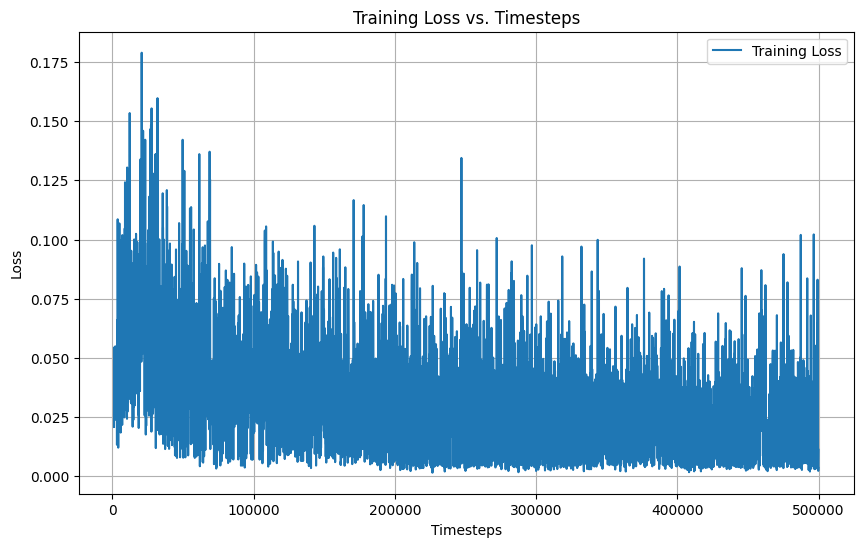

Mean reward: 0.76


In [6]:
# Create environment
env = Connect4Env()

# Create model
model = DQN(
    policy="MlpPolicy",
    env=env,
    learning_rate=1e-3,
    buffer_size=50_000,
    learning_starts=1_000,
    batch_size=64,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.05,
    target_update_interval=500,
    verbose=1,
    tensorboard_log="./connect4_dqn_tensorboard/"
)

# Train the model with the callback
loss_logger_callback = LossLoggerCallback()
model.learn(total_timesteps=500_000, callback=loss_logger_callback)

# Save the model
model.save("connect4_dqn_model")

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(loss_logger_callback.timesteps, loss_logger_callback.losses, label="Training Loss")
plt.xlabel("Timesteps")
plt.ylabel("Loss")
plt.title("Training Loss vs. Timesteps")
plt.legend()
plt.grid()
plt.show()

# Evaluate the model
eval_env = Monitor(Connect4Env())
mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=100)
print(f"Mean reward: {mean_reward}")